In [ ]:
# !pip install -U gdown ultralytics scikit-learn albumentations

In [ ]:
# Download ICDAR 2003 dataset
# https://drive.google.com/file/d/1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV/view

# !gdown 1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
# !unzip -q icdar2003.zip -d datasets

In [3]:
import os
import xml.etree.ElementTree as ET
import shutil
import yaml
import json

import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import ultralytics
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Extract Data from XML and Store in YOLO format

In [4]:
def extract_data_from_xml(root_dir):
    """Extract data from an XML file containing image metadata, bounding boxes, and labels."""
    xml_path = os.path.join(root_dir, "words.xml")
    tree = ET.parse(xml_path) # Parse XML file
    root = tree.getroot() # Get root element

    img_paths = []
    img_sizes, img_labels = [], []
    bboxes = []

    for img in root: # Iterate through <image> elements
        bbs_of_img, labels_of_img = [], []
        for bbs in img.findall("taggedRectangles"): # Find <taggedRectangles>
            for bb in bbs: # Iterate through <taggedRectangle>
                # Skip if <tag> text is not alphanumeric 
                if not bb[0].text.isalnum():
                    continue
                
                # Skip if <tag> text is contains unwanted characters
                if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
                    continue
                
                # Append bounding box attributes and label
                bbs_of_img.append(
                    [
                        float(bb.attrib["x"]),
                        float(bb.attrib["y"]),
                        float(bb.attrib["width"]),
                        float(bb.attrib["height"])
                    ]
                )
                labels_of_img.append(bb[0].text.lower())

        # Collect image path, size, bounding boxes, and labels
        img_path = os.path.join(root_dir, img[0].text) # Path from <image>
        img_paths.append(img_path)
        img_sizes.append((int(img[1].attrib["x"]), int(img[1].attrib["y"]))) # Size from <size>
        bboxes.append(bbs_of_img)
        img_labels.append(labels_of_img)

    return img_paths, img_sizes, img_labels, bboxes

In [5]:
dataset_dir = "/kaggle/working/datasets/SceneTrialTrain"
image_paths, image_sizes, image_labels, bounding_boxes = extract_data_from_xml(dataset_dir)

print(f"Number of images: {len(image_paths)}")
print("=" * 100)
print(f"Example image path: {image_paths[0]}")
print(f"Example image size: {image_sizes[0]}")
print(f"Example bounding boxes: {bounding_boxes[0][:2]}")
print(f"Example labels: {image_labels[0][:2]}")

Number of images: 250
Example image path: /kaggle/working/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG
Example image size: (1600, 1200)
Example bounding boxes: [[174.0, 392.0, 274.0, 195.0], [512.0, 391.0, 679.0, 183.0]]
Example labels: ['self', 'adhesive']


## Convert to YOLO format

In [6]:
def convert_to_yolo_format(image_paths, image_sizes, bounding_boxes):
    """Converts image bounding boxes to YOLO format."""
    
    yolo_data = []

    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        yolo_labels = []

        for bbox in bboxes:
            x, y, w, h = bbox

            # Calculate normalized bounding box coordinates
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            # Because we only have one class, we set class_id=0
            class_id = 0

            # Convert to YOLO format
            yolo_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolo_labels.append(yolo_label)

        yolo_data.append((image_path, yolo_labels))
    return yolo_data

In [7]:
class_labels = ["text"]

yolo_data = convert_to_yolo_format(image_paths, image_sizes, bounding_boxes)

## Train Val Test split

In [8]:
seed = 0

train_data, test_data = train_test_split(
    yolo_data,
    test_size=0.2,
    random_state=seed,
    shuffle=True
)

test_data, val_data = train_test_split(
    test_data,
    test_size=0.125,
    random_state=seed,
    shuffle=True
)

len(train_data), len(val_data), len(test_data)

(200, 7, 43)

## Save data

In [9]:
def save_data(data, save_dir):
    """Saves images and their corresponding YOLO labels to specified directories."""
    
    # Create folder if not exists
    os.makedirs(save_dir, exist_ok=True)

    # Make images and labels folder
    os.makedirs(os.path.join(save_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "labels"), exist_ok=True)

    for image_path, yolo_labels in data:
        # Copy image to the images folder
        shutil.copy(image_path,
                    os.path.join(save_dir, "images"))

        # Extract image name and save labels
        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        # Write YOLO labels to the label file
        with open(os.path.join(save_dir, "labels", f"{image_name}.txt"), "w") as f:
            for label in yolo_labels:
                f.write(f"{label}\n")

In [10]:
dataset_dir = "/kaggle/working/datasets/SceneTrialTrain"
save_yolo_data_dir = "/kaggle/working/datasets/yolo_data"
os.makedirs(save_yolo_data_dir, exist_ok=True)

save_train_dir = os.path.join(save_yolo_data_dir, "train")
save_data(train_data, save_train_dir)

save_val_dir = os.path.join(save_yolo_data_dir, "val")
save_data(val_data, save_val_dir)

save_test_dir = os.path.join(save_yolo_data_dir, "test")
save_data(test_data, save_test_dir)

## Create data.yaml file

In [11]:
data_yaml = {
    "path": "/kaggle/working/datasets/yolo_data",
    "train": "train/images",
    "val": "val/images",
    "test": "test/images",
    "nc": 1,
    "names": class_labels
}

yolo_yaml_path = os.path.join(save_yolo_data_dir, "data.yml")
with open(yolo_yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

## Training

In [12]:
ultralytics.checks()

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6037.7/8062.4 GB disk)


In [13]:
# Load model
model = YOLO("yolo11m.pt")

# Train model
results = model.train(
    data=yolo_yaml_path,
    epochs=100,
    imgsz=640,
    cache=True,
    patience=20,
    plots=True
)

100%|██████████| 38.8M/38.8M [00:00<00:00, 206MB/s]


Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/kaggle/working/datasets/yolo_data/data.yml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

100%|██████████| 755k/755k [00:00<00:00, 26.8MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 116MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/yolo_data/train/labels... 200 images, 7 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 972.13it/s]

train: New cache created: /kaggle/working/datasets/yolo_data/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.2GB RAM): 100%|██████████| 200/200 [00:00<00:00, 430.03it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/yolo_data/val/labels... 7 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7/7 [00:00<00:00, 2472.22it/s]

val: New cache created: /kaggle/working/datasets/yolo_data/val/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 7/7 [00:00<00:00, 95.22it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.89G       2.06      3.004      1.812         24        640: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all          7         62       0.21      0.194     0.0922     0.0401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.79G      1.207      1.413       1.18         64        640: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all          7         62      0.141      0.323      0.109     0.0441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.68G      1.303      1.309      1.226         51        640: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all          7         62     0.0311      0.565     0.0224    0.00806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.63G      1.309      1.295      1.239         44        640: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all          7         62    0.00405     0.0806    0.00217   0.000638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.68G      1.265      1.163      1.187         28        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all          7         62    0.00365     0.0645     0.0056   0.000724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.71G      1.394      1.218      1.252         29        640: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]

                   all          7         62    0.00365     0.0645     0.0056   0.000724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.65G      1.425      1.349      1.254         78        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

                   all          7         62    0.00365     0.0645     0.0056   0.000724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.82G      1.346      1.156      1.233         55        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all          7         62    0.00365     0.0645     0.0056   0.000724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.61G      1.323      1.139      1.221         68        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all          7         62     0.0327      0.258     0.0148    0.00427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.82G      1.312      1.147      1.249         61        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all          7         62      0.322       0.29        0.2     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.69G       1.21      1.019      1.189         31        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all          7         62      0.147       0.21      0.133     0.0654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       8.7G      1.199     0.9875      1.132         66        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all          7         62      0.146      0.403      0.083     0.0308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.09G      1.173     0.9702      1.173         44        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all          7         62       0.26      0.226      0.162     0.0836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.84G      1.229      1.061        1.2         38        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]

                   all          7         62      0.538      0.371      0.385      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.68G      1.168      1.036      1.149         60        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all          7         62      0.413      0.397      0.298      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.99G      1.228     0.9533      1.189         42        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all          7         62      0.457      0.435      0.402      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.91G      1.221       1.03      1.183         35        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all          7         62       0.19      0.129     0.0644     0.0298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.82G      1.162      1.016      1.162         48        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all          7         62      0.399      0.306      0.284      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       8.7G      1.175     0.9522      1.134         58        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all          7         62      0.673      0.399      0.416      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.71G      1.117     0.9378       1.12         74        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all          7         62      0.363      0.403      0.305      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      9.07G       1.11     0.8778      1.095         48        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all          7         62      0.532      0.419      0.445      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.73G      1.099     0.8771       1.11         67        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

                   all          7         62      0.565      0.607      0.562      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.03G      1.035     0.8401      1.085         56        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all          7         62      0.623      0.508      0.487       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.68G      1.049     0.8479      1.085         73        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all          7         62      0.617      0.484      0.499      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.63G      1.055     0.8224      1.064         30        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all          7         62      0.622      0.548      0.547      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.73G      1.045     0.7945      1.077         80        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all          7         62      0.644      0.532      0.519      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.67G      1.067     0.8639      1.115         38        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all          7         62      0.432      0.601       0.49      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.98G     0.9983     0.7975      1.081         42        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all          7         62      0.531      0.629      0.546      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.61G      1.025     0.8238      1.081         47        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all          7         62      0.501      0.694      0.524      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.68G      1.074     0.8109      1.103         45        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all          7         62      0.455      0.661      0.458      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.69G      1.021     0.8528      1.098         31        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all          7         62      0.631      0.694      0.636      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.69G     0.9504     0.7556      1.038         41        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all          7         62      0.639      0.572      0.577      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       8.9G     0.9777     0.7506      1.059         59        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all          7         62      0.525      0.613      0.522       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.69G     0.9485     0.7521      1.027         57        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]

                   all          7         62      0.656      0.524      0.618       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.82G     0.9149     0.7443      1.038         25        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]

                   all          7         62      0.576        0.7       0.62      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.84G     0.9434     0.7225      1.032         51        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all          7         62      0.638      0.512      0.549      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.65G      0.921     0.7089      1.031         59        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all          7         62      0.548      0.703      0.647      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       8.7G      0.917     0.7379      1.025         33        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all          7         62      0.516      0.741      0.631      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.76G     0.9143     0.7156      1.021         37        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]

                   all          7         62      0.463      0.709      0.534      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.71G     0.9218     0.6918      1.021         65        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

                   all          7         62      0.586      0.726      0.657      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      9.08G     0.9031     0.6996      1.027         34        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all          7         62      0.526      0.629      0.578      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.99G     0.8935     0.6742     0.9963         37        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all          7         62      0.696      0.613      0.655      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.74G     0.9079      0.684      1.017         34        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all          7         62      0.617      0.624       0.59      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.73G     0.9068      0.647      1.029         54        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all          7         62      0.516      0.694      0.591      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.67G      0.899     0.6487     0.9874         44        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all          7         62      0.626      0.694      0.684      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.91G     0.8533     0.6189     0.9855         54        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all          7         62      0.627      0.726      0.704       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.98G     0.8713      0.642      1.002         70        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all          7         62      0.698      0.745      0.781      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.69G     0.8324      0.639      1.009         44        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all          7         62      0.639      0.839      0.776      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       9.1G      0.851     0.6475     0.9792         50        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all          7         62       0.74      0.735      0.769      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.82G     0.8567     0.6216     0.9965         25        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all          7         62      0.679      0.718      0.733      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.99G     0.8284     0.6203     0.9954         36        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]

                   all          7         62      0.661      0.758      0.739      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.68G     0.8575     0.6127     0.9942         44        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all          7         62      0.726      0.599      0.747      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       8.9G     0.8175     0.5975     0.9845         32        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all          7         62      0.616      0.661      0.661      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.82G     0.8609      0.607     0.9941         34        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]

                   all          7         62      0.707      0.532      0.601      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.82G     0.8158     0.6162     0.9938         77        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all          7         62      0.875      0.565       0.71      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.68G       0.88     0.6177     0.9991         38        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all          7         62      0.655      0.774       0.77      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.78G     0.8533     0.6232      1.001         55        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all          7         62      0.677      0.661      0.675      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.72G     0.7985     0.5645     0.9737         61        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

                   all          7         62      0.667      0.694      0.671      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.69G     0.7778     0.5569     0.9566         50        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all          7         62      0.645       0.71      0.698      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.69G     0.7714     0.5818     0.9715         48        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all          7         62      0.749      0.581      0.687      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      8.61G       0.78     0.5705     0.9776         45        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all          7         62      0.679      0.661      0.729      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.84G      0.748     0.5488     0.9692         38        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all          7         62      0.691      0.694      0.688      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.69G     0.7758     0.5498     0.9727         94        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all          7         62      0.651      0.662      0.697      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       8.7G     0.7647      0.576     0.9712         52        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

                   all          7         62      0.698      0.744      0.744      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       8.6G     0.7399      0.545     0.9583         51        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all          7         62      0.715       0.77      0.765      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.69G      0.754     0.5417     0.9639         65        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

                   all          7         62      0.669      0.749      0.752      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.73G     0.7794     0.5668     0.9671         70        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all          7         62      0.821      0.665      0.769      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.88G     0.7474     0.5386     0.9444         67        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all          7         62      0.724      0.694      0.765      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.76G     0.7465     0.5382     0.9587         53        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all          7         62      0.577       0.79      0.672      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.75G       0.73     0.5211     0.9317         50        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all          7         62      0.586      0.677      0.648      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.68G     0.7589     0.5141     0.9684         95        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all          7         62      0.644      0.642      0.672      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.77G     0.7709     0.5369     0.9646         43        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all          7         62       0.73      0.677      0.709      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.67G     0.7239      0.503     0.9445         55        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

                   all          7         62      0.794      0.774      0.787      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.71G      0.728     0.5024     0.9361         69        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all          7         62      0.729      0.726      0.764      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.96G     0.6994     0.5076     0.9551         29        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all          7         62      0.646      0.726      0.741       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.68G        0.7     0.4957     0.9288         76        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all          7         62      0.719       0.71      0.703       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.63G     0.7164     0.5012     0.9537         78        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all          7         62      0.653      0.759        0.7       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.84G     0.7118     0.4929     0.9406         40        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all          7         62      0.714      0.726      0.715      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.68G     0.6853     0.4863     0.9307         47        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all          7         62      0.719      0.702      0.726      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.68G     0.7156      0.483      0.955         46        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all          7         62      0.694       0.79      0.747      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.64G     0.6581     0.4495     0.9312         51        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all          7         62      0.671      0.822      0.795      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.77G     0.6763     0.4678     0.9381         81        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all          7         62      0.868      0.636      0.791      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.97G     0.6606     0.4526     0.9354         50        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all          7         62      0.717       0.71      0.752      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.68G     0.6806     0.4672      0.924         81        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all          7         62       0.76      0.677      0.771      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.61G     0.6562     0.4776     0.9356         65        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all          7         62      0.697      0.742      0.744       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.84G     0.6437     0.4482     0.9359         56        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all          7         62      0.674      0.742      0.719      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.75G      0.638     0.4521     0.9163         70        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all          7         62      0.701      0.757      0.707      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.69G      0.637     0.4583      0.926         87        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all          7         62      0.694      0.758      0.728      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.64G     0.6402     0.4384     0.9184         64        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all          7         62      0.725      0.764      0.744      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.72G     0.6289     0.4517     0.9153         67        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all          7         62      0.696      0.739      0.721      0.502


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.68G      0.684      0.509     0.9247         47        640: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all          7         62      0.697      0.758      0.736      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.73G     0.6808     0.4876     0.9158         50        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all          7         62      0.723      0.717       0.75      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.65G     0.6671     0.4886      0.916         19        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all          7         62      0.665       0.79      0.755      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      8.66G     0.6536     0.4561     0.9029         54        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

                   all          7         62      0.693      0.823      0.779      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.81G     0.6753     0.4635     0.9071         29        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all          7         62      0.746      0.823      0.785      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.97G     0.6161     0.4503     0.8894         21        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

                   all          7         62      0.746      0.806      0.773       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.61G     0.6479     0.4399     0.8959         33        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all          7         62      0.722      0.823      0.795      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.82G     0.6227     0.4414     0.8926         33        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all          7         62      0.722       0.79      0.787      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.82G     0.6194     0.4395     0.8988         18        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all          7         62      0.704      0.806      0.773       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.81G     0.6468     0.4264     0.9008         36        640: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all          7         62      0.687       0.79      0.767       0.52



100 epochs completed in 0.303 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


                   all          7         62      0.868      0.638      0.791      0.533
Speed: 0.2ms preprocess, 14.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


## Evaluation

In [14]:
model_path = "/kaggle/working/runs/detect/train/weights/best.pt"
model = YOLO(model_path)

metrics = model.eval()

## Inference

In [15]:
def visualize_bbox(img_path, predictions, conf_thres=0.8, font=cv2.FONT_HERSHEY_SIMPLEX):
    """ Visualizes bounding boxes with confidence scores on an image."""
    
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction["confidence"]

        # Skip predictions with low confidence
        if conf_score < conf_thres:
            continue 

        bbox = prediction["box"]
        xmin = int(bbox["x1"])
        ymin = int(bbox["y1"])
        xmax = int(bbox["x2"])
        ymax = int(bbox["y2"])

        # Draw bounding box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)

        # Prepare text and its background
        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        # Draw background for text
        cv2.rectangle(
            img,
            (xmin, ymin - text_height - 5),
            (xmin + text_width, ymin),
            (0, 255, 0),
            -1
        )

        # Put the confidence score text on the image
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)

    return img

In [16]:
model_path = "/kaggle/working/runs/detect/train/weights/best.pt"
model = YOLO(model_path)
conf_thres = 0.75


image 1/1 /kaggle/working/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1255.JPG: 480x640 6 texts, 45.9ms
Speed: 2.5ms preprocess, 45.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


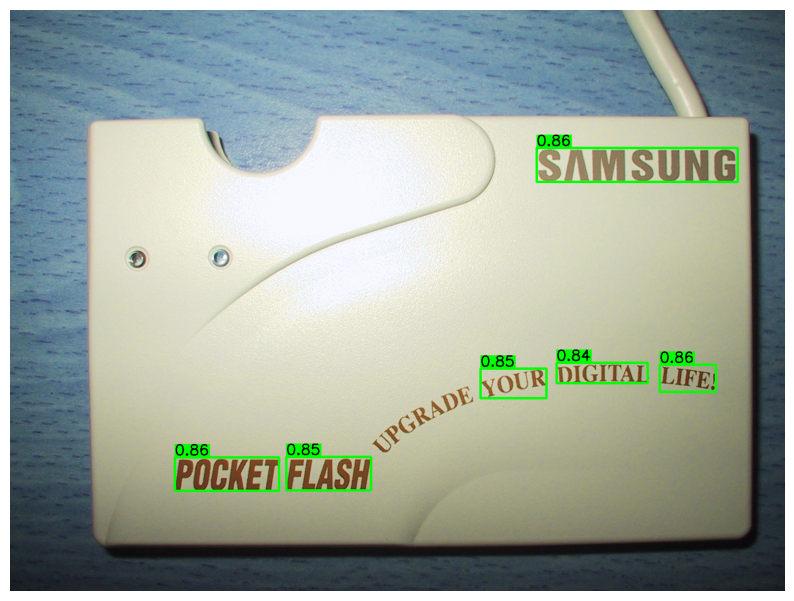

In [17]:
img_path = "/kaggle/working/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1255.JPG"
results = model(img_path, conf=conf_thres)
predictions = json.loads(results[0].to_json())
visualized_img = visualize_bbox(img_path, predictions)

plt.figure(figsize=(10, 10))
plt.imshow(visualized_img)
plt.axis("off")
plt.show()


image 1/1 /kaggle/working/datasets/SceneTrialTrain/ryoungt_03.09.2002/PICT0042.JPG: 480x640 3 texts, 15.4ms
Speed: 2.3ms preprocess, 15.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


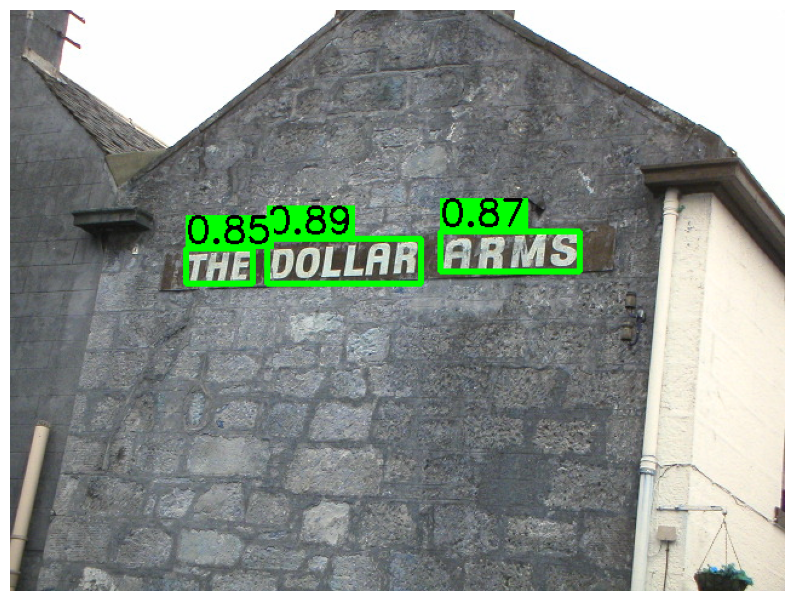

In [19]:
img_path = "/kaggle/working/datasets/SceneTrialTrain/ryoungt_03.09.2002/PICT0042.JPG"

results = model(img_path, conf=conf_thres)
predictions = json.loads(results[0].to_json())
visualized_img = visualize_bbox(img_path, predictions)

plt.figure(figsize=(10, 10))
plt.imshow(visualized_img)
plt.axis("off")
plt.show()